# Signal Modulation classification 2
Train relatively simple model for signal modulation classification with the intention to deploy it on the CFU-Playground

[Reference](https://www.mathworks.com/help/deeplearning/ug/modulation-classification-with-deep-learning.html)

In [14]:
# imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
# from komm import PAModulation
# from commpy.filters import rrcosfilter
import time
import glob
from pathlib import Path
from scipy import io
from typing import Tuple
import os
from tqdm import tqdm
from tensorflow.keras.callbacks import LearningRateScheduler

In [15]:
SEED = 123456
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

## Data generation/loading for model training/evaluation/training

In [16]:
classes = [
    "16QAM",
    "64QAM",
    "8PSK",
    "B-FM",
    "BPSK",
    "CPFSK",
    "DSB-AM",
    "GFSK",
    "PAM4",
    "QPSK",
    "SSB-AM",
]

N_CLASSES = len(classes)
MODEL_DATA_TYPE = np.float64
N_SAMPLES = 1024

MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

### Data preprocessing
The only thing I gonna to is to divide two parts of complex numbers into separate float number

### Data loading
Data is created in matlab using different impairments techniques, and rician fading simulation

In [17]:
generate = False


def preprocess_data(samples: np.ndarray) -> np.ndarray:
    I = np.real(samples)
    Q = np.imag(samples)
    return np.hstack([I, Q]).astype(MODEL_DATA_TYPE)


def generate_data(classes):
    # TODO: Make data generation code work
    # set_seed(SEED)
    # N = 1024
    # os = 8
    # # Random bits
    # d = np.random.randint(low=0, high=4, size=N)

    # # PAM 4 modulation
    # pam4 = PAModulation(4)
    # db = pam4.symbols_to_bits(d)
    # syms = pam4.modulate(db)

    # # Square-root raised cosine filter
    # syms_upsampled = np.zeros(os * (len(syms) - 1) + 1, dtype=np.complex64)
    # syms_upsampled[::os] = syms
    # filterCoeffs = rrcosfilter(N, alpha=0.35, Ts=4, Fs=os)[1]
    # tx = np.convolve(filterCoeffs, syms_upsampled)

    # # Channel
    # SNR = 30
    # maxOffset = 5
    # fc = 902e6
    # fs = 200e3
    raise NotImplementedError()


def load_data(classes, path=Path("train_data")) -> Tuple[np.ndarray, np.ndarray]:
    before = time.time()
    # train_data = {}
    labels = []
    data = []

    n_data = 0
    for cl_idx, cl in enumerate(classes):
        mat_files = glob.glob(f"{path}/*{cl}*.mat")
        for mat_file in mat_files:
            np_data = io.loadmat(mat_file)["frame"]
            np_data = preprocess_data(np_data)
            n_data += len(np_data)

            labels.append(cl_idx)
            data.append(np_data)
    after = time.time()
    print(f"[debug] Loaded train data with size {n_data} in {after - before}s")
    return np.array(labels), np.expand_dims(np.array(data), axis=1)


In [18]:
if generate:
    labels, data = generate_data(classes)
else:
    labels, data = load_data(classes=classes)

[debug] Loaded train data with size 112640000 in 41.22203516960144s


There are 10_000 samples of size 1024x2 (complex numbers) for each of 11 modulations

In [19]:
print(len(labels))
print(data.shape)
print(data[0].shape)
print(data[0][:10])

110000
(110000, 1, 1024, 2)
(1, 1024, 2)
[[[ 0.95451608 -0.19869544]
  [ 0.78964504 -0.65876765]
  [ 0.46299981 -0.82472679]
  ...
  [ 0.18117962  0.2227802 ]
  [-0.08828134  0.20730375]
  [-0.12365668  0.25967789]]]


## Model creation


In [20]:
DS_SIZE = len(labels)

n_train = int(0.8 * DS_SIZE)
n_validation = int(0.1 * DS_SIZE)
n_test = DS_SIZE - n_train - n_validation

random_indecies = np.arange(DS_SIZE)
np.random.shuffle(random_indecies)

train_indecies, validation_indecies, test_indecies, _ = np.split(
    random_indecies, [int(DS_SIZE * 0.8), int(DS_SIZE * 0.9), DS_SIZE]
)


In [21]:
train_data, train_labels = data[train_indecies], labels[train_indecies]
validation_data, validation_labels = data[validation_indecies], labels[validation_indecies]
test_data, test_labels = data[test_indecies], labels[test_indecies]

In [22]:
del data
del labels

In [23]:
def MyBatchNormalization_f(inputs, name):
    mean = tf.reduce_mean(inputs)
    mean_expanded = tf.ones(inputs.shape) * mean
    std = tf.keras.backend.std(inputs)
    TempSub = layers.Subtract()([inputs, mean_expanded])
    Normalized = layers.Multiply(name=name)([TempSub, 1 / std])
    return Normalized


# https://github.com/dksakkos/BatchNorm
class CustomBatchNorm(layers.Layer):
    def __init__(self, *args, **kwargs):
        super(CustomBatchNorm, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.beta = self.add_weight(
            name="custom_batch_beta",
            shape=(input_shape[-1]),
            initializer="zeros",
            trainable=True,
        )

        self.gamma = self.add_weight(
            name="custom_batch_gamma",
            shape=(input_shape[-1]),
            initializer="ones",
            trainable=True,
        )

        self.moving_mean = self.add_weight(
            name="custom_batch_moving_mean",
            shape=(input_shape[-1]),
            initializer=tf.initializers.zeros,
            trainable=False,
        )

        self.moving_variance = self.add_weight(
            name="custom_batch_moving_variance",
            shape=(input_shape[-1]),
            initializer=tf.initializers.ones,
            trainable=False,
        )

    def get_moving_average(self, statistic, new_value):
        momentum = 0.9
        new_value = statistic * momentum + new_value * (1 - momentum)
        return statistic.assign(new_value)

    def normalise(self, x, x_mean, x_var):
        return (x - x_mean) / tf.sqrt(x_var + 1e-6)

    def call(self, inputs, training):
        if training:
            assert len(inputs.shape) in (2, 4)
            if len(inputs.shape) > 2:
                axes = [0, 1, 2]
            else:
                axes = [0]
            mean, var = tf.nn.moments(inputs, axes=axes, keepdims=False)
            self.moving_mean.assign(self.get_moving_average(self.moving_mean, mean))
            self.moving_variance.assign(self.get_moving_average(self.moving_variance, var))
        else:
            mean, var = self.moving_mean, self.moving_variance
        x = self.normalise(inputs, mean, var)
        return self.gamma * x + self.beta


def create_model_v1():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(16, (1, 8), padding="same", name="CNN1_")(InputLayer)
    # N1 = layers.LayerNormalization()
    BN1 = CustomBatchNorm(name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)

    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)
    CNN2 = layers.Conv2D(24, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = CustomBatchNorm(name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)

    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)
    CNN3 = layers.Conv2D(32, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = CustomBatchNorm(name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)

    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)
    CNN4 = layers.Conv2D(48, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = CustomBatchNorm(name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)

    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)
    CNN5 = layers.Conv2D(64, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = CustomBatchNorm(name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)

    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)
    CNN6 = layers.Conv2D(96, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = CustomBatchNorm(name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    # FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Flatten(name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model


def create_model_v2():
    # InputLayer = keras.Input(shape=(1, 1024, 2))
    # ReLU1 = layers.Conv2D(16, (1, 8), padding="valid", name="CNN1_", activation="relu")(InputLayer)

    # MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)
    # ReLU2 = layers.Conv2D(24, (1, 8), padding="valid", name="CNN2_", activation="relu")(MaxPool1)

    # MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)
    # ReLU3 = layers.Conv2D(32, (1, 8), padding="valid", name="CNN3_", activation="relu")(MaxPool2)

    # MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)
    # ReLU4 = layers.Conv2D(48, (1, 8), padding="valid", name="CNN4_", activation="relu")(MaxPool3)

    # MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)
    # ReLU5 = layers.Conv2D(64, (1, 8), padding="valid", name="CNN5_", activation="relu")(MaxPool4)

    # MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)
    # ReLU6 = layers.Conv2D(96, (1, 8), padding="valid", name="CNN6_", activation="relu")(MaxPool5)

    # AP1 = layers.MaxPool2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    # FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(InputLayer)
    # FC1 = layers.Dense(11, name="FC1_")(FC1)

    # SoftMax = layers.Softmax()(FC1)
    # Output = layers.Reshape((11,))(FC1)

    # model = keras.Model(inputs=[InputLayer], outputs=[FC1])
    m = tf.keras.Sequential()
    m.add(layers.Conv2D(16, (1, 8), input_shape=(1, 1024, 2), padding="valid", name="CNN1_", activation="relu"))
    m.add(layers.Flatten())
    # m.add(layers.Reshape((1, 1, -1), name="FC1_preFlatten1"))
    m.add(layers.Dense(11, name="FC1_"))

    return m


def create_model_original():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(16, (1, 8), padding="same", name="CNN1_")(InputLayer)
    BN1 = layers.BatchNormalization(epsilon=0.000010, name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)
    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)

    CNN2 = layers.Conv2D(24, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = layers.BatchNormalization(epsilon=0.000010, name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)
    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)

    CNN3 = layers.Conv2D(32, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = layers.BatchNormalization(epsilon=0.000010, name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)
    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)

    CNN4 = layers.Conv2D(48, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = layers.BatchNormalization(epsilon=0.000010, name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)
    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)

    CNN5 = layers.Conv2D(64, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = layers.BatchNormalization(epsilon=0.000010, name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)
    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)

    CNN6 = layers.Conv2D(96, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = layers.BatchNormalization(epsilon=0.000010, name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)
    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model


In [24]:
model = create_model_v1()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1024, 2)]      0         
_________________________________________________________________
CNN1_ (Conv2D)               (None, 1, 1024, 16)       272       
_________________________________________________________________
BN1_ (CustomBatchNorm)       (None, 1, 1024, 16)       64        
_________________________________________________________________
re_lu_6 (ReLU)               (None, 1, 1024, 16)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 512, 16)        0         
_________________________________________________________________
CNN2_ (Conv2D)               (None, 1, 512, 24)        3096      
_________________________________________________________________
BN2_ (CustomBatchNorm)       (None, 1, 512, 24)        96  

In [25]:
# https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/ 
# learning rate schedule
def step_decay(epoch):
    lrate = 0.02
    factor = epoch // 9
    lrate /= (10**factor)
    return lrate

lrate = LearningRateScheduler(step_decay)

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [27]:
h = model.fit(
    train_data,
    train_labels,
    epochs=12,
    batch_size=32,
    validation_data=(validation_data, validation_labels), 
    callbacks=[lrate]
)


2023-02-18 14:15:59.723355: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 720896000 exceeds 10% of free system memory.
2023-02-18 14:16:00.538268: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-18 14:16:00.542026: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1997405000 Hz


Epoch 1/12
2750/2750 [==============================] - 101s 36ms/step - loss: 0.8365 - accuracy: 0.6668 - val_loss: 0.3808 - val_accuracy: 0.8004
Epoch 2/12
2750/2750 [==============================] - 104s 38ms/step - loss: 0.3887 - accuracy: 0.7968 - val_loss: 0.3433 - val_accuracy: 0.8075
Epoch 3/12
2750/2750 [==============================] - 101s 37ms/step - loss: 0.3439 - accuracy: 0.8170 - val_loss: 0.3167 - val_accuracy: 0.8268
Epoch 4/12
2750/2750 [==============================] - 88s 32ms/step - loss: 0.3126 - accuracy: 0.8332 - val_loss: 0.3043 - val_accuracy: 0.8301
Epoch 5/12
2750/2750 [==============================] - 98s 35ms/step - loss: 0.2944 - accuracy: 0.8465 - val_loss: 0.2715 - val_accuracy: 0.8590
Epoch 6/12
2750/2750 [==============================] - 105s 38ms/step - loss: 0.2682 - accuracy: 0.8681 - val_loss: 0.2476 - val_accuracy: 0.8807
Epoch 7/12
2750/2750 [==============================] - 107s 39ms/step - loss: 0.2375 - accuracy: 0.8891 - val_loss: 0.2

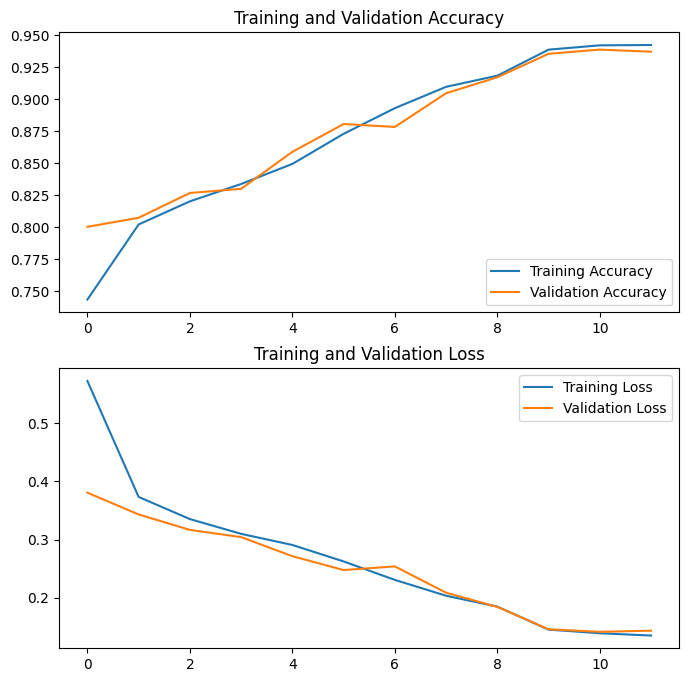

In [29]:
import matplotlib.pyplot as plt

acc = h.history['accuracy']
val_acc = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs_range = range(12)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [30]:
test_preds = model.predict(test_data)

In [39]:
pred_labels = np.argmax(test_preds, axis=1)
print(pred_labels[0:10])
print(test_labels[0:10])

[5 7 3 9 6 8 7 3 0 2]
[5 7 3 9 6 8 7 3 0 9]


Overall test accuracy: 0.9359090909090909
16QAM test accuracy: 0.8315688161693936
64QAM test accuracy: 0.7682186234817814
8PSK test accuracy: 0.9375600384245918
B-FM test accuracy: 1.0
BPSK test accuracy: 1.0
CPFSK test accuracy: 0.9971014492753624
DSB-AM test accuracy: 0.9776195320447609
GFSK test accuracy: 0.9989361702127659
PAM4 test accuracy: 0.9951267056530214
QPSK test accuracy: 0.8670694864048338
SSB-AM test accuracy: 0.9241952232606438


<AxesSubplot:>

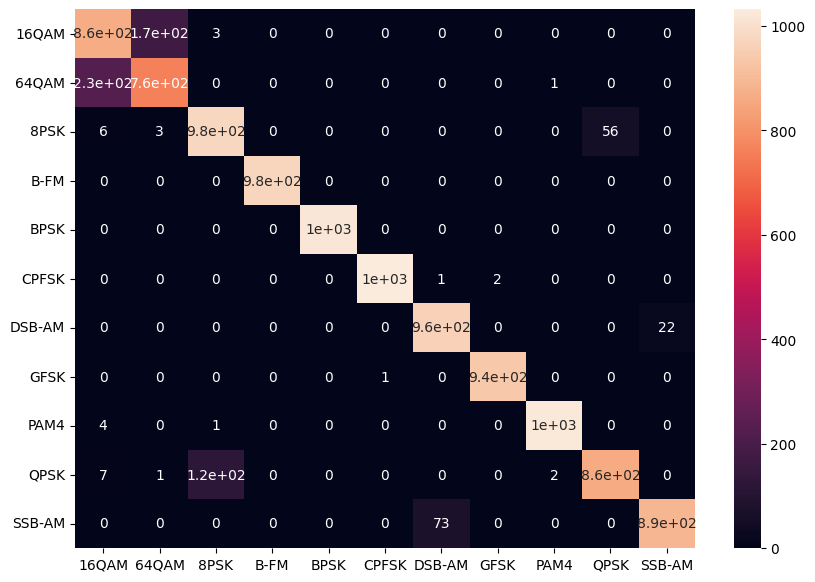

In [42]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Overall test accuracy: {accuracy_score(test_labels, pred_labels)}")
for ci, cl in enumerate(classes):
    class_indecies = np.where(test_labels == ci)[0]
    cur_test_labels = test_labels[class_indecies]
    cur_pred_labels = pred_labels[class_indecies]
    print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")
cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

### Mode deployment

In [27]:
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


In [28]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(2000):
    yield([train_data[i].reshape((1, 1, 1024, 2)).astype(np.float32)])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

2023-02-18 13:01:59.438098: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2023-02-18 13:01:59.438123: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.
2023-02-18 13:01:59.438127: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:325] Ignored change_concat_input_ranges.
2023-02-18 13:01:59.439359: I tensorflow/cc/saved_model/reader.cc:32] Reading SavedModel from: models/model
2023-02-18 13:01:59.443997: I tensorflow/cc/saved_model/reader.cc:55] Reading meta graph with tags { serve }
2023-02-18 13:01:59.444027: I tensorflow/cc/saved_model/reader.cc:93] Reading SavedModel debug info (if present) from: models/model
2023-02-18 13:01:59.445004: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-18 13:01:59.457897: I tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2023-02-18 13:01:59.

113976

In [29]:
def predict_tflite(tflite_model, x_test):
    # Prepare the test data
    x_test_ = x_test.copy()
    # x_test_ = x_test_.reshape((x_test.size, 1))
    x_test_ = x_test_.astype(np.float32)

    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    # experimental_op_resolver_type=tf.lite.experimental.OpResolverType.BUILTIN_REF)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # If required, quantize the input layer (from float to integer)
    input_scale, input_zero_point = input_details["quantization"]
    if (input_scale, input_zero_point) != (0.0, 0):
        x_test_ = x_test_ / input_scale + input_zero_point
        x_test_ = x_test_.astype(input_details["dtype"])

    # Invoke the interpreter
    y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
    # for i in range(len(x_test_)):
    #     interpreter.set_tensor(input_details["index"], [x_test_[i]])
    #     interpreter.invoke()
    #     y_pred[i] = interpreter.get_tensor(output_details["index"])[0]
    interpreter.set_tensor(input_details["index"], x_test_)
    interpreter.invoke()
    y_pred = interpreter.get_tensor(output_details["index"])[0]

    # If required, dequantized the output layer (from integer to float)
    output_scale, output_zero_point = output_details["quantization"]
    if (output_scale, output_zero_point) != (0.0, 0):
        y_pred = y_pred.astype(np.float32)
        y_pred = (y_pred - output_zero_point) * output_scale

    return y_pred


In [30]:
def export_model_micro(tflite_model_path):
    os.system(f"xxd -i {tflite_model_path} > {MODEL_TFLITE_MICRO}")
    # Update variable names
    REPLACE_TEXT = MODEL_TFLITE.replace("/", "_").replace(".", "_")
    os.system(f"sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}``")

def np_to_c_array(arr: np.ndarray, arr_name="arr") -> str:
    if arr.dtype == np.float32:
        type_specifier = "float"
    elif arr.dtype == np.float64:
        type_specifier = "float"
    elif arr.dtype == np.uint8:
        type_specifier = "unsigned char"
    elif arr.dtype == np.int8:
        type_specifier = "char"
    else:
        raise NotImplementedError(f"Type {arr.dtype} is not supported")
    res = f"{type_specifier} {arr_name}[] = "   
    
    # res += np.array2string(arr.flatten(), separator=",").replace("[", "{").replace("]", "}")
    # res += ";"

    # very ineffective
    res += "{"
    for v in arr.flatten():
        res += str(v) + ","
    res = res[:-1]
    res += "};"

    return res


def export_test_data(
    model, data: np.ndarray, labels: np.ndarray, file: str, tests_per_class=1, predict=lambda model, data: model.predict(data), model_name="MODEL_1"
):
    print("[debug] Export test")
    with open(file, "w") as res_file:
        res_file.write(f"#ifndef {model_name}\n")
        res_file.write(f"#define {model_name}\n\n")
        for ci, cl in tqdm(enumerate(classes)):
            # indecies = random.sample(range(len(test_data[cl])), tests_per_class)
            indecies = [np.where(labels == ci)[0][0]]
            for i in indecies:
                data = test_data[i].reshape((1, 1, 1024, 2))
                pred = predict(model, data)
                data_str = np_to_c_array(data, arr_name=f"test_data_{cl}_{i}_{model_name}".replace('-', ''))
                pred_str = np_to_c_array(pred, arr_name=f"pred_{cl}_{i}_{model_name}".replace('-', ''))
                res_file.write(data_str + "\n")
                res_file.write(pred_str + "\n")
                res_file.write("\n\n")
        res_file.write(f"#endif // {model_name}\n")


In [31]:
model_name = "signal_modulation_2"
test_data_file = "test_data.h"


export_model_micro(MODEL_NO_QUANT_TFLITE)
# export_model_micro(MODEL_TFLITE)
export_test_data(model_no_quant_tflite, test_data, test_labels, file=test_data_file, predict=predict_tflite, model_name=model_name)


[debug] Export test


11it [00:00, 435.71it/s]
